<img style="float: left;" src="images\EP_Logo.png" alt="UoE" width="300px"/>
<img style="float: right;" src="images\UoE_Logo.png" alt="UoE" width="300px"/>
<img style="float: left;" src="images\urban_rural_scape.png" alt="UoE" width="1000px"/>

# Gaussian Plume Modelling
Jupyter notebook for ECSC09005 Environmental Pollution  
author: John Moncrieff *for* Session 2020-21  [version 0.12, latest 19:51, 7 Feb 2021]
## Background
As discussed in the lecture series, the gaussian plume model has been applied in many different situations either to understand a given air pollution episode or to predict the impact of say a new factory or motorway on future air quality in a particular area. In this jupyter notebook, I want us to explore the sensitivity of ground-level concentration of various pollutants to changes in driving variables such as wind speed and direction and chimney height. Let's examine a real-life example where a local community has been impacted by gas flaring from a local industrial complex in Fife, just north of Edinburgh. If you want some background on this example, have a look at a couple of web reports from the BBC: https://www.bbc.co.uk/news/uk-scotland-edinburgh-east-fife-51498166  and https://www.bbc.co.uk/news/uk-scotland-edinburgh-east-fife-49720751 
<img style="float: right;" src="images\flaring.png" alt="Mossmorran flaring" width="260px"/></p>
## Imports
Let's start by importing some libraries to the environment:
- *matplotlib inline* for creating inline plots
- *scipy* for various mathematical functions
- *pandas* to order and sort data in a convenient Table-like format
- *numpy* for numerical routines
- *matplotlib* for plotting data
- *ipywidgets* for interactivity
- *config* for python code that just takes up space in the main notebook
- *pyproj* to allow us to convert from GPS coordinates to eastings and northings
- *requests* so we can download a streetmap via a URL query
- *pil* to handle images

In [1]:
import numpy as np
import sys
from scipy.special import erfcinv as erfcinv
import tqdm as tqdm
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import ticker, cm
from src import gauss_func, overlay_on_map, calc_sigmas, smooth
#from src import config as cfg
from src import streetimg as stmap
from src.ltgpinterface import ltgpinterface
from src import ytv, gpdraw, sigmaplot, cfg
from pyproj import Proj, transform
import ipywidgets as widgets
from IPython.display import display
#from io import BytesIO
#from PIL import Image
#import requests

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
# for Palatino and other serif fonts use:
rc('font', **{'family': 'serif', 'serif': ['Palatino']})
# rc('text', usetex = False)
print('imports OK')

imports OK


The gaussian plume equation requires a number of parameters such as wind speed, the effective height of emission, emission strength and the spreading parameters $\sigma_y$ and $\sigma_z$ :  
>$\large x = \frac{Q}{\ \pi\sigma_y \sigma_z u} \exp[ - \frac{1}{\ 2} (\frac{y}{\ \sigma_y})^2] \exp[ - \frac{1}{\ 2} (\frac{H}{\ \sigma_z})^2]$  
where  
$x$ is the ground-level concentration (typically $\mu g m^{-3}$)  
$Q$ is the source emission strength (often $g \ s^{-1}$)  
$u$ is the surface wind speed (usually $m \ s^{-1}$)  
$\sigma_y, \sigma_z$ are the spreading parameters in the $y$ and $z$ directions respectively (units of $m$) and functions of atmospheric stability  
$H$ is the effective plume height ($m$)  
$exp$ is the base of natural logarithms ie the exponential function


### Pasquill dispersion classes  
(Surface wind speed in $m \ s^{-1}$)

| Insolation   | Cloud cover       | Wind Speed | Wind Speed | Wind Speed | Wind Speed | Wind Speed |
|--------------|-------------------|------------|------------|------------|------------|------------|
|              |                   | <2         | 2-3        | 3-5        | 5-6        | >6         |
| Day          | Strong            | A          | A-B        | B          | C          | C          |
|              | Moderate          | A-B        | B          | B-C        | C-D        | D          |
|              | Slight            | B          | C          | C          | D          | D          |
| Day or night | Overcast          | D          | D          | D          | D          | D          |
| Night        | Thin or CC >= 0.5 |            | E          | D          | D          | D          |
|              | CC <=0.4          |            | F          | E          | D          | D          |
|              |                   |            |            |            |            |            |


How do we get $\sigma_y$ and $\sigma_z$?

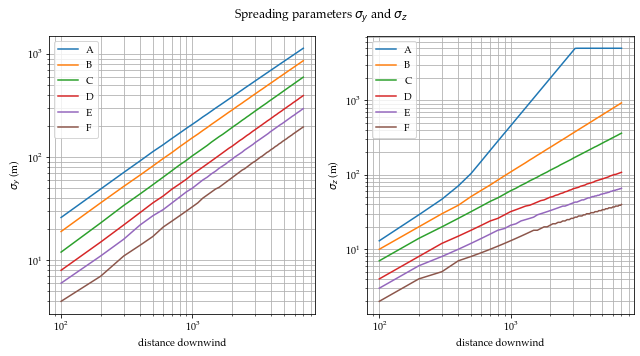

In [2]:
sigmaplot.sigmaplot()


### First,  prepare a background image.
This shows the local towns and roads over which we'll project the output from the model. This cell only needs to be run once at the start of the program.

In [ ]:
# Get the map Data
# Get more than one tile for a 4 x 4 km box centred on
# the main sources of emission - Fife Ethylene Plant in this example
# I used Google Earth to find the lat-lon coordinates
lat_max = 56.132276
lat_min = 56.060534
lon_min = -3.3733
lon_max = -3.244456
mp = stmap.stmap(lat_max,lat_min,lon_min,lon_max,13)
mp.run()

# image now stored in memory for later use. 
# If the map below looks OK, proceed to initialise the model.

### Configuration - edit the input options below as appropriate.
Now let's load up some default information that will provide the initial configuration of variables such as wind speed and direction, stack height and location etc.

In [ ]:
fd = ltgpinterface()                        # make a copy of the configuration
widgets.VBox(children=[fd.h1,fd.h2,fd.h3])  # show the options which we will select and play with


In [ ]:
print(fd.stack)   # just double-checking the input data before running the model!
# prints a python dictionary which is arranged in key:value pairs eg "wind" = 3 ms-1.

In [ ]:
cfg.cfg()

<div class="alert alert-block alert-info">
</div>

### Next we do the calculations. Depending on how many stacks you've chosen and the number of days to model, this might take several seconds to complete. A progress bar shows, well, progress.

In [ ]:
# SECTION 3: Main loop
# For all times...
C1 = np.zeros((len(x), len(y), len(wind_dir)))
for i in tqdm.tqdm(range(0, len(wind_dir))):
    for j in range(0, stacks):
        C = np.ones((len(x), len(y)))
        C = gauss_func.gauss_func(Q[j], wind_speed[i], wind_dir[i], x, y, z,
                       stack_x[j], stack_y[j], H[j], Dy, Dz, stability[i])
        C1[:, :, i] = C1[:, :, i] + C

### And now the fun part - what does the simulation show?

In [ ]:
# SECTION 4: Post process / output
gpdraw.gpdraw(output)

### At this point, you can go back to the configuration cell and chose something else to change eg a different wind speed or direction, a different atmospheric stability, more chimneys etc.